In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn.model_selection import KFold

In [3]:
from fastai.callbacks.tracker import *
from fastai.text import *
from fastai.tabular import *
from fastai_tab_text import *

In [4]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

In [5]:
mercari_path = Path('data/')

# Prepare data

In [6]:
def preprocess_text_cols(df: pd.DataFrame) -> pd.DataFrame:
  
    df['category_name'] = df['category_name'].fillna('//')
    df['category1'] = df['category_name'].apply(lambda x : x.split('/')[0].strip())
    df.loc[df.category1=='','category1']= np.NaN
    df['category2'] = df['category_name'].apply(lambda x : x.split('/')[1].strip())
    df.loc[df.category2=='','category2']= np.NaN
    df['category3'] = df['category_name'].apply(lambda x : x.split('/')[2].strip())
    df.loc[df.category3=='','category3']= np.NaN
    df['category_name'] = df['category_name'].apply( lambda x : ' '.join( x.split('/') ).strip() )
    df.loc[df.category_name=='','category_name']= 'No category' # let this info in when concatenating text for RNN
    
    df_bn_fillna = df['brand_name'].fillna('No brand')
    df['text'] = (df['name'].fillna('No name') + '. ' + df_bn_fillna + '. ' + 
                  df['category_name'] + '. ' + df['item_description'].fillna('No description'))
    return df[['category1','category2','category3','brand_name', 'text', 'shipping', 'item_condition_id','price']]

def preprocess_all(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price
    
    test = pd.read_table(mercari_path/'test_stg2.tsv').drop('test_id',axis=1)
    test['price'] = np.NAN
    train = train[train['price'] > 0].reset_index(drop=True)
    all_df = pd.concat([train,test],axis=0).reset_index(drop=True)
    del train
    del test
    gc.collect()
#     if sample:
#         np.random.seed(42)
#         sample = np.random.permutation(sample)
#         train = train.loc[sample].reset_index(drop=True)

    all_df = preprocess_text_cols(all_df)
    
    return all_df
def preprocess_train(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price

    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train = train.loc[sample].reset_index(drop=True)

    train = preprocess_text_cols(train)

    return train
def get_val_idxs(train,n_splits=20):
    np.random.seed(42)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idxs, valid_idxs = next(cv.split(train))
    return train_idxs,valid_idxs

In [7]:
n=1482535 # train shape

In [8]:
train_df = preprocess_train(int(.03*n))
train_df.shape

(44476, 8)

In [9]:
train_df.price = np.log1p(train_df['price']) # so we can use MSE in NN

In [10]:
cat_names=['category1','category2','category3','brand_name','shipping']
# cont_names= list(set(train.columns) - set(cat_names) - {'AdoptionSpeed'})
cont_names= list(set(train_df.columns) - set(cat_names) - {'price','text'})
print(f'# of continuous feas: {len(cont_names)}')
print(f'# of categorical feas: {len(cat_names)}')
dep_var = 'price'
procs = [FillMissing,Categorify, Normalize]

txt_cols=['text']

len(cat_names) + len(cont_names) + 2 == train_df.shape[1]

# of continuous feas: 1
# of categorical feas: 5


True

In [11]:
train_idxs,val_idxs = get_val_idxs(train_df,n_splits=10)
train_idxs,val_idxs
train_idxs.shape,val_idxs.shape

(array([    0,     1,     2,     3, ..., 44472, 44473, 44474, 44475]),
 array([    4,     7,    40,    49, ..., 44424, 44438, 44445, 44457]))

((40028,), (4448,))

In [12]:
def get_tabulartext_databunch(bs=100,val_idxs=val_idxs,path=mercari_path):
    data_lm = load_data(path, 'data_lm.pkl', bs=bs)
    collate_fn = partial(mixed_tabular_pad_collate, pad_idx=1, pad_first=True)
    reset_seed()
    return (TabularTextList.from_df(train_df, cat_names, cont_names, txt_cols, vocab=data_lm.vocab, procs=procs, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var)
#                             .add_test(TabularTextList.from_df(test, cat_names, cont_names, txt_cols,path=path))
                            .databunch(bs=bs,collate_fn=collate_fn, no_check=False))

In [13]:
encoder_name = 'bs60-awdlstm-enc-stage2'
def get_tabtext_lr_find(data,params,seed=42):
    reset_seed(seed)
    learn_lf = tabtext_learner(data,AWD_LSTM,metrics=[root_mean_squared_error],**params).to_fp16()
    learn_lf.load_encoder(encoder_name)
    return learn_lf.to_fp32()

def get_tabulartext_learner(data,params,seed=42):
    reset_seed(seed)
    learn= tabtext_learner(data,AWD_LSTM,metrics=[root_mean_squared_error],
                               callback_fns=[partial(SaveModelCallback, monitor='root_mean_squared_error',mode='min',every='improvement',name='best_nn')],
                               **params).to_fp16()
    learn.load_encoder(encoder_name)
    return learn

# stage 1

In [14]:
params={
    'layers':[500,400,200],
    'bptt':70,
    'max_len':20*70,
    'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
    'lin_ftrs': [300],
    'ps_lin_ftrs': [0],
    'ps': [0.001,0,0],
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
}
bs=100

In [15]:
data = get_tabulartext_databunch(bs=bs)

In [17]:
learn = get_tabtext_lr_find(data,params,seed=42).to_fp32()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


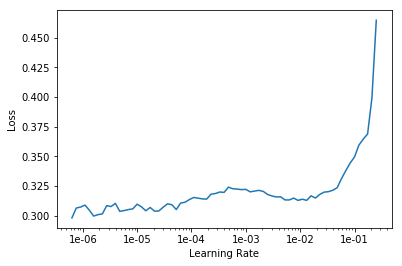

In [21]:
_=learn.load('temp1')
gc.collect()
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [18]:
learn = get_tabulartext_learner(data,params,seed=42).to_fp32()
gc.collect()

153

In [19]:
learn.fit_one_cycle(2,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.374204,0.371318,0.604306,02:02
1,0.329129,0.348524,0.585446,02:01


Better model found at epoch 0 with root_mean_squared_error value: 0.6043059229850769.
Better model found at epoch 1 with root_mean_squared_error value: 0.5854463577270508.


In [30]:
# learn.fit_one_cycle(3,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.457749,0.393187,0.625363,00:39
1,0.371698,0.337614,0.579418,00:39
2,0.320161,0.332637,0.575189,00:39


Better model found at epoch 0 with root_mean_squared_error value: 0.6253625750541687.
Better model found at epoch 1 with root_mean_squared_error value: 0.5794180035591125.
Better model found at epoch 2 with root_mean_squared_error value: 0.5751887559890747.


In [20]:
# learn.save('temp1')

In [22]:
learn = get_tabtext_lr_find(data,params,seed=42).to_fp32()
_=learn.load('temp1')
gc.collect()

11

In [23]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-05,1e-03),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.301406,0.344652,0.582179,05:06
1,0.316974,0.336493,0.574820,05:07


In [21]:
# learn.unfreeze()
# learn.fit_one_cycle(5,max_lr=slice(1e-06,8e-04),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.293322,0.326228,0.569505,01:43
1,0.295367,0.332587,0.575211,01:44
2,0.304284,0.322180,0.566263,01:42
3,0.288383,0.324699,0.568140,01:42
4,0.287395,0.324750,0.568179,01:45


In [19]:
learn.unfreeze()
learn.fit_one_cycle(1,max_lr=slice(1e-06,1e-04),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.294495,0.335348,0.577498,01:41
1,0.287542,0.328527,0.571548,01:42
2,0.299809,0.330349,0.573148,01:42
3,0.291962,0.323944,0.567475,01:43
4,0.296757,0.324230,0.567679,01:44


In [17]:
# learn.unfreeze()
# learn.fit_one_cycle(5,max_lr=slice(1.5e-06,4e-05),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.295371,0.332972,0.575451,01:42
1,0.288805,0.329607,0.572507,01:42
2,0.301661,0.332245,0.574773,01:42
3,0.292274,0.324797,0.568222,01:43
4,0.297009,0.325818,0.569094,01:44


In [25]:
# learn.freeze_to(-2)
# learn.fit_one_cycle(1,max_lr=slice(1e-05,3e-04),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.310943,0.335388,0.577758,00:50


In [153]:
# learn.fit_one_cycle(4,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.493848,0.346415,0.587800,00:38
1,0.392703,0.375146,0.610408,00:38
2,0.341316,0.325856,0.569676,00:38
3,0.304012,0.319580,0.563768,00:38


Better model found at epoch 0 with root_mean_squared_error value: 0.5877997875213623.
Better model found at epoch 2 with root_mean_squared_error value: 0.5696762800216675.
Better model found at epoch 3 with root_mean_squared_error value: 0.5637679696083069.


In [148]:
# params={
#     'layers':[500,200,100],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [300],
#     'ps_lin_ftrs': [0],
#     'ps': [0.001,0.01,0],
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=160
# learn.fit_one_cycle(4,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.491284,0.368734,0.606353,00:38
1,0.393837,0.356004,0.594548,00:38
2,0.340752,0.328317,0.571813,00:38
3,0.302183,0.321478,0.565397,00:39


Better model found at epoch 0 with root_mean_squared_error value: 0.606352686882019.
Better model found at epoch 1 with root_mean_squared_error value: 0.5945475101470947.
Better model found at epoch 2 with root_mean_squared_error value: 0.5718128681182861.
Better model found at epoch 3 with root_mean_squared_error value: 0.5653970241546631.


In [144]:
# params={
#     'layers':[500,200,100],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [300],
#     'ps_lin_ftrs': [0],
#     'ps': [0.01,0,0],
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=160
# learn.fit_one_cycle(4,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.493846,0.429104,0.653575,00:38
1,0.395507,0.345336,0.585665,00:38
2,0.340096,0.324664,0.568578,00:38
3,0.301711,0.322196,0.566304,00:39


Better model found at epoch 0 with root_mean_squared_error value: 0.6535751819610596.
Better model found at epoch 1 with root_mean_squared_error value: 0.5856654047966003.
Better model found at epoch 2 with root_mean_squared_error value: 0.5685781240463257.
Better model found at epoch 3 with root_mean_squared_error value: 0.5663036704063416.


In [132]:
# params={
#     'layers':[500,200,100],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [300],
#     'ps_lin_ftrs': [0],
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=160
# learn.fit_one_cycle(4,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.491759,0.362901,0.601719,00:38
1,0.392879,0.344217,0.584863,00:38
2,0.342886,0.322263,0.566235,00:38
3,0.303403,0.324691,0.568224,00:38


Better model found at epoch 0 with root_mean_squared_error value: 0.6017189025878906.
Better model found at epoch 1 with root_mean_squared_error value: 0.584863007068634.
Better model found at epoch 2 with root_mean_squared_error value: 0.5662351846694946.


In [125]:
# params={
#     'layers':[1000,800],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [300],
#     'ps_lin_ftrs': [0],
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=160
# learn.fit_one_cycle(4,max_lr=3e-03,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.591034,0.598132,0.772947,00:38
1,0.431274,0.338375,0.580686,00:38
2,0.357075,0.352426,0.591758,00:38
3,0.325217,0.321156,0.565075,00:37


Better model found at epoch 0 with root_mean_squared_error value: 0.772946834564209.
Better model found at epoch 1 with root_mean_squared_error value: 0.5806857943534851.
Better model found at epoch 3 with root_mean_squared_error value: 0.5650749206542969.


In [114]:
# params={
#     'layers':[1000,800],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [200],
#     'ps_lin_ftrs': [0],
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=160
# learn.fit_one_cycle(4,max_lr=3e-03,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.589302,0.709070,0.841480,00:38
1,0.430315,0.394613,0.626915,00:38
2,0.360243,0.332992,0.575737,00:38
3,0.322125,0.323762,0.567482,00:38


Better model found at epoch 0 with root_mean_squared_error value: 0.8414801955223083.
Better model found at epoch 1 with root_mean_squared_error value: 0.6269147396087646.
Better model found at epoch 2 with root_mean_squared_error value: 0.575736939907074.
Better model found at epoch 3 with root_mean_squared_error value: 0.567482054233551.


In [106]:
# learn.fit_one_cycle(4,max_lr=3e-03,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.579370,0.427674,0.653506,00:38
1,0.426073,0.383988,0.618939,00:38
2,0.361907,0.326580,0.570574,00:38
3,0.326879,0.316452,0.561157,00:38


Better model found at epoch 0 with root_mean_squared_error value: 0.6535059809684753.
Better model found at epoch 1 with root_mean_squared_error value: 0.6189391613006592.
Better model found at epoch 2 with root_mean_squared_error value: 0.5705739259719849.
Better model found at epoch 3 with root_mean_squared_error value: 0.5611568689346313.


In [94]:
# params={
#     'layers':[1000,500],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [100],
#     'ps_lin_ftrs': [0],
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=160
# learn.fit_one_cycle(4,max_lr=3e-03,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.561193,0.415435,0.643755,00:37
1,0.412999,0.345504,0.587103,00:37
2,0.359064,0.327147,0.570451,00:38
3,0.319049,0.325347,0.568935,00:38


Better model found at epoch 0 with root_mean_squared_error value: 0.6437553763389587.
Better model found at epoch 1 with root_mean_squared_error value: 0.5871034264564514.
Better model found at epoch 2 with root_mean_squared_error value: 0.5704505443572998.
Better model found at epoch 3 with root_mean_squared_error value: 0.5689345002174377.


In [90]:
# params={
#     'layers':[1000,500],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [100],
#     'ps_lin_ftrs': [0.05],
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=160
# learn.fit_one_cycle(4,max_lr=3e-03,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.555403,0.513504,0.715292,00:38
1,0.411900,0.338592,0.581090,00:38
2,0.357547,0.334185,0.576832,00:38
3,0.320162,0.329410,0.572374,00:38


Better model found at epoch 0 with root_mean_squared_error value: 0.7152920365333557.
Better model found at epoch 1 with root_mean_squared_error value: 0.5810903906822205.
Better model found at epoch 2 with root_mean_squared_error value: 0.5768318772315979.
Better model found at epoch 3 with root_mean_squared_error value: 0.5723740458488464.


In [84]:
# params={
#     'layers':[1000,500],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [50],
#     'ps_lin_ftrs': [0.1],
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=160
# learn.fit_one_cycle(4,max_lr=3e-03,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.569736,0.497820,0.704238,00:38
1,0.411551,0.344538,0.585527,00:38
2,0.353614,0.327816,0.571286,00:38
3,0.321359,0.335778,0.577965,00:38


Better model found at epoch 0 with root_mean_squared_error value: 0.704237699508667.
Better model found at epoch 1 with root_mean_squared_error value: 0.5855271816253662.
Better model found at epoch 2 with root_mean_squared_error value: 0.5712860822677612.


In [77]:
# params={
#     'layers':[500,200],
#     'bptt':70,
#     'max_len':20*70,
#     'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
#     'lin_ftrs': [50],
#     'ps_lin_ftrs': [0.1],
#     'ps': None,
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# bs=180
# 1%
# learn.fit_one_cycle(4,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.476132,0.398845,0.630696,00:35
1,0.389079,0.360870,0.599738,00:36
2,0.338664,0.330467,0.574033,00:37
3,0.308899,0.331175,0.574617,00:36


Better model found at epoch 0 with root_mean_squared_error value: 0.6306961178779602.
Better model found at epoch 1 with root_mean_squared_error value: 0.5997379422187805.
Better model found at epoch 2 with root_mean_squared_error value: 0.5740325450897217.


In [59]:
# 3%
# learn.fit_one_cycle(3,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.376960,0.396846,0.626014,01:59
1,0.328361,0.355420,0.592391,02:00
2,0.305817,0.353427,0.590345,02:01


Better model found at epoch 0 with root_mean_squared_error value: 0.6260137557983398.
Better model found at epoch 1 with root_mean_squared_error value: 0.5923912525177002.
Better model found at epoch 2 with root_mean_squared_error value: 0.5903449058532715.


In [42]:
# 5%
# learn.fit_one_cycle(3,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.370297,0.338513,0.579393,02:54
1,0.326743,0.339801,0.580735,02:53
2,0.301308,0.317136,0.560875,02:55


In [18]:
# 50%
# learn.fit_one_cycle(3,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.334035,0.320535,0.563829,11:57
1,0.310734,0.309240,0.553604,11:57
2,0.296536,0.302858,0.547888,11:59


Better model found at epoch 0 with root_mean_squared_error value: 0.5638288855552673.
Better model found at epoch 1 with root_mean_squared_error value: 0.5536041855812073.
Better model found at epoch 2 with root_mean_squared_error value: 0.5478876829147339.


In [19]:
# learn.save('version2-50pct-stage1')

In [25]:

# learn.fit_one_cycle(5,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.398566,0.365835,0.601927,01:18
1,0.376464,0.338829,0.578204,01:18
2,0.338271,0.333970,0.573566,01:18
3,0.321110,0.327015,0.566773,01:18
4,0.293169,0.323621,0.563851,01:19


In [26]:
# learn.save('version2-stage1')

# Tune 2

In [27]:
params={
    'layers':[500,200],
    'bptt':70,
    'max_len':20*70,
    'drop_mult': 1., # drop_mult: multiply to different dropouts in AWD LSTM
    'lin_ftrs': [50],
    'ps_lin_ftrs': [0.1],
    'ps': None,
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
}
bs=100

In [28]:
data = get_tabulartext_databunch(bs=bs)

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


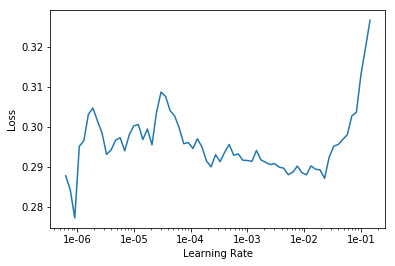

In [30]:
learn = get_tabtext_lr_find(data,params,seed=42).to_fp32()
_=learn.load('version2-stage1');
gc.collect()
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


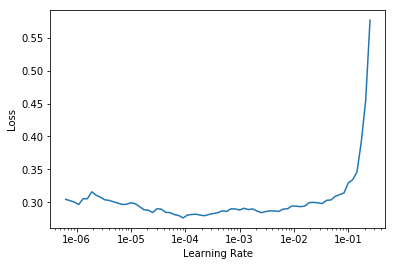

In [33]:
_=learn.load('version2-stage1');
gc.collect()
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot()

In [35]:
learn = get_tabtext_lr_find(data,params,seed=42).to_fp32()
_=learn.load('version2-stage1');
learn.fit_one_cycle(3,max_lr=slice(1e-05,1e-03),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.285587,0.315873,0.557165,01:19
1,0.285786,0.316151,0.557276,01:20
2,0.269703,0.319143,0.559815,01:18


In [31]:
# learn.model

SequentialMultipleInput(
  (0): MultiBatchMixEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(33781, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(33781, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearTabularTextClassifier(
    (rnn_lin_layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.4)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): Batc